<font size = "5"> **Chapter 4:  [Spectroscopy](Ch4-Spectroscopy.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of Core-Loss Spectra
<br>

part of 

<font size = "5"> **[Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)**</font>

by Gerd Duscher, 2020

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes




## Content

Quantitative determination of chemical composition from a core-loss EELS spectrum


Relavant notebooks in course [MSE 672: Introduction to TEM]()  give an in depth explanation of the method.

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## Prerequesites
This notebook will only run with  ``version 0.2022.6.0`` or higher.

### Install missing packages
This can take a while for the first time. This code will have to run at least once on you computer or colab session.

In [ ]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists without loading nd returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2022.9.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

In [5]:
import sys
!{sys.executable} -m pip install https://github.com/pycroscopy/pyTEMlib/master/

  ERROR: HTTP error 404 while getting https://github.com/pycroscopy/pyTEMlib/master/
ERROR: Could not install requirement https://github.com/pycroscopy/pyTEMlib/master/ because of HTTP error 404 Client Error: Not Found for url: https://github.com/pycroscopy/pyTEMlib/master/ for URL https://github.com/pycroscopy/pyTEMlib/master/


### Load the relevant packages

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pylab as plt
%gui qt

import sys
sys.path.insert(0, '../../')
import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it
import pyTEMlib.eels_tools  as eels        # EELS methods 

import pyTEMlib.interactive_eels as ieels  # Dialogs for EELS input and quantification

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ', pyTEMlib.__version__)

__notebook__ = 'analyse_core_loss'
__notebook_version__ = '2022_09_24'

Symmetry functions of spglib enabled
SimpleITK not installed; Registration Functions for Image Stacks not available
install with: conda install -c simpleitk simpleitk 
pyTEM version:  0.2022.11.0


## Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

First a dialog to select a file will apear.

Then the spectrum plot and ``Spectrum Info`` dialog will appear, in which we set the experimental parameters.

Please use the ``Set Energy Scale`` button to change the energy scale. When pressed a new dialog and a cursor will appear in which one is able to set the energy scale based on known features in the spectrum.


<IPython.core.display.Javascript object>


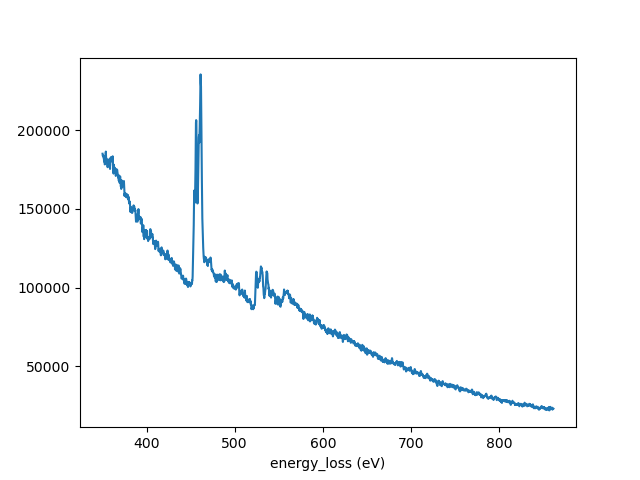

In [2]:
datasets={'main_dataset': ft.open_file()}
dataset = datasets['main_dataset']

if 'experiment' not in dataset.metadata:
    print('kkk')
    dataset.metadata['experiment']= eels.read_dm3_eels_info(dataset.original_metadata)
if dataset.data_type.name in ['SPECTRUM', 'SPECTRAL_IMAGE']:
    info = ieels.InfoDialog(dataset)
else:
    print('We really need a spectrum here')
    datasets['main_dataset'].plot()

In [ ]:
info.plot()

In [ ]:
dataset.view.axis.set_xlabel('energy_loss (eV)')

In [ ]:
dset.original_metadata.keys()

## Chemical Composition 
The fit of the cross-section and background to the spectrum results in the chemical composition. If the calibration is correct this composition is given as areal density in atoms/nm$^2$


###  Fit of Data
A dialog window will open, enter the elements first (0 will open a periodic table) and press 
``Fit Composition`` button (bottom right). Adjust parameters as needed and check fit by pressing the ``Fit Composition`` button again.

Select the ``Region`` checkbox to see which parts of the spectrum you choose to fit.

Changing the multiplier value will make a simulation of your spectrum.

The ``InfoDialog``, if open, still works to change experimental parameters and the energy scale.

<IPython.core.display.Javascript object>


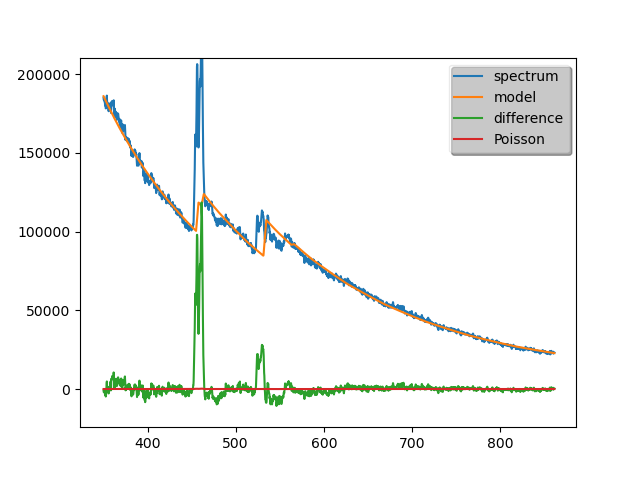

In [7]:
composition = ieels.CompositionDialog(dataset)

### Output of Results

In [5]:
edges = dataset.metadata['edges']
element = []
areal_density = []
for key, edge in edges.items():
    if key.isdigit():
        element.append(edge['element'])
        areal_density.append(edge['areal_density'])

print('Relative chemical composition of ', dataset.title)
for i in range(len(element)):
    print(f'{element[i]}: {areal_density[i]/np.sum(areal_density)*100:.1f} %')
    
saved_edges_metadata = edges

Relative chemical composition of  EELS_STO
Ti: 18.6 %
O: 81.4 %


### Log Data
We write all the data to the hdf5 file associated with our dataset.

In our case that is only the ``metadata``, in which we stored the ``experimental parameters`` and the ``fitting parameters and result``.

In [ ]:
import sidpy
current_group = dataset.h5_dataset.parent.parent
if 'Log_000' not in current_group:
    log_group = current_group.create_group('Log_000')
    
log_group = current_group['Log_000']
if 'analysis' in log_group:
    del log_group['analysis'] 
log_group['analysis'] = 'EELS_quantification'

sidpy.hdf.hdf_utils.write_simple_attrs(log_group, dataset.metadata)
current_group.file.flush()

In [ ]:
ft.h5_tree(current_group.file)

## ELNES
The electron energy-loss near edge structure is determined by fititng the spectrum after quantification model subtraction. 

First smooth the spectrum (only 0 iteration available at this time) and then 
find the number of peaks you want (Can be repeated as oftern as one wants).

Please note that the peaks do not necessarily have a physcial meaning as there are peaks with 
positive and negative amplitudes. The goal is to get a smooth representation of the spectrum.
A difference of a good fit and the data should result in a residual of noise only. To achieve such a good fit, the careful setting of the edge onset is important.


<IPython.core.display.Javascript object>


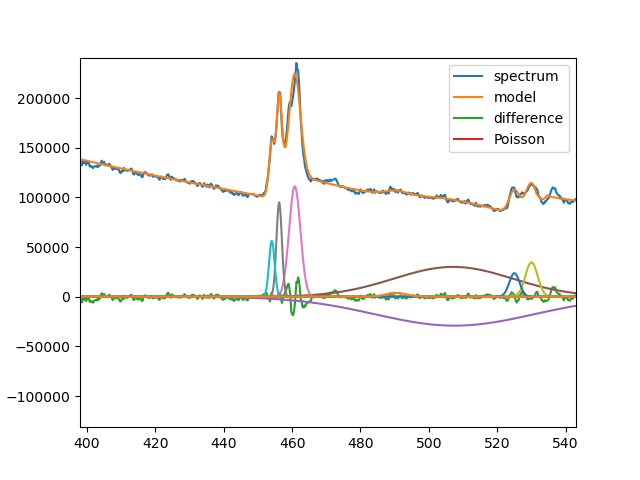

In [6]:
peak_dialog = ieels.PeakFitDialog(dataset)

### Output

In [ ]:
areas = []
for p, peak in peak_dialog.peaks['peaks'].items():
    area = np.sqrt(2* np.pi)* peak['amplitude'] * np.abs(peak['width'] / np.sqrt(2 *np.log(2))) 
    areas.append(area)
    if 'associated_edge' not in peak:
        peak['associated_edge']= ''
    print(f"peak  {p}: position: {peak['position']:7.1f}, area: {area:12.3f} associated edge: {peak['associated_edge']}")
#print(f'\n M4/M5 peak 2 to peak 1 ratio: {(areas[1])/areas[0]:.2f}')

### Log Data

In [ ]:
current_group = dataset.h5_dataset.parent
if 'Log_001' not in current_group:
    log_group = current_group.create_group('Log_001')
    
log_group = current_group['Log_001']
if 'analysis' in log_group:
    del log_group['analysis'] 
log_group['analysis'] = 'ELNES_fit'
sidpy.hdf.hdf_utils.write_simple_attrs(log_group, dataset.metadata)
current_group.file.flush()

print('Logged Data of ', dataset.title)
for key in current_group:
    if 'Log_' in key:
        if 'analysis' in current_group[key]:
            print(f" {key}: {current_group[key]['analysis'][()]}")

## Close File
File needs to be closed to be used with other notebooks

In [ ]:
dataset.h5_dataset.file.close()

## Navigation
<font size = "5"> **Back: [Calculating Dielectric Function II: Silicon](DielectricDFT2.ipynb)** </font>

<font size = "5"> **Next: [ELNES](ELNES.ipynb)** </font>

<font size = "5"> **Chapter 4: [Spectroscopy](Spectroscopy.ipynb)** </font>

<font size = "5"> **Index: [Index](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)** </font>

In [ ]:
%pylab notebook

t = np.arange(0.0, 0.2, 0.1)
y1 = 2*np.sin(2*np.pi*t)
y2 = 4*np.sin(2*np.pi*2*t)

fig, ax = plt.subplots()
ax.set_title('Click on legend line to toggle line on/off')
line1, = ax.plot(t, y1, lw=2, label='1 HZ')
line2, = ax.plot(t, y2, lw=2, label='2 HZ')
leg = ax.legend(loc='upper left', fancybox=True, shadow=True)
leg.get_frame().set_alpha(0.4)


# we will set up a dict mapping legend line to orig line, and enable
# picking on the legend line
lines = [line1, line2]
lined = dict()
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(5)  # 5 pts tolerance
    lined[legline] = origline


def onpick(event):
    # on the pick event, find the orig line corresponding to the
    # legend proxy line, and toggle the visibility
    legline = event.artist
    origline = lined[legline]
    vis = not origline.get_visible()
    origline.set_visible(vis)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled
    if vis:
        legline.set_alpha(1.0)
    else:
        legline.set_alpha(0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', onpick)

plt.show()


In [ ]:
print(lined)

In [ ]:
line3, = ax.plot(t, y2-1, lw=2, label='3 HZ')
legline= leg.get_lines()[-1]
legline.set_pickradius (5)  # 5 pts tolerance
lined[legline] = origline
fig.canvas.draw_idle()